In [2]:
pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 4.2 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install py-ecg-detectors 

     -------------------------------------- 554.5/554.5 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py install for gatspy: started
  Running setup.py install for gatspy: finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  DEPRECATION: gatspy is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install imblearn

     -------------------------------------- 226.0/226.0 kB 2.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import os
import wfdb
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from scipy.signal import cheby2, filtfilt, iirnotch
from ecgdetectors import Detectors
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [11]:

# ... (remaining code for functions and data loading)
#Preprocess the ECG signal (you might have your own preprocessing steps)
def cheby2_bandpass_filter(data, lowcut, highcut, fs, order=5, rs=30):
    #nyq = 0.5 * fs
    #low = lowcut / nyq
    #high = highcut / nyq
    #b, a = cheby2(order, rs, [low, high], btype='band')
    #y = filtfilt(b, a, data)
    y = data
    return y


def notch_filter(data, notch_freq, q, fs):
    nyq = 0.5 * fs
    freq = notch_freq / nyq
    b, a = iirnotch(freq, q)
    y = filtfilt(b, a, data)
    return y

import scipy.signal as signal
def process_ecg_data(ecg_signal, fs, target_fs):
    if fs != target_fs:
        ecg_signal = signal.resample(ecg_signal, int(ecg_signal.size * target_fs / fs))
    filtered_ecg_signal = cheby2_bandpass_filter(ecg_signal, 0.5, 100, target_fs, order=6, rs=30)
    filtered_ecg_signal = notch_filter(filtered_ecg_signal, 50, 30, target_fs)
    return filtered_ecg_signal
def extract_beats_and_annotations(record_path, annotation_path, fs, target_fs, window_size=186):
    record = wfdb.rdrecord(record_path)
    annotation = wfdb.rdann(annotation_path, 'atr')

    # Process the ECG signal
    processed_ecg_signal = process_ecg_data(record.p_signal[:, 0], fs, target_fs)

    detectors = Detectors(target_fs)
    r_peaks = detectors.two_average_detector(processed_ecg_signal)

    beat_locations = []
    beat_annotations = []

    half_window = window_size // 2
    for i, r_peak in enumerate(r_peaks):
        if r_peak - half_window >= 0 and r_peak + half_window < len(processed_ecg_signal):
            beat_location = processed_ecg_signal[r_peak - half_window:r_peak + half_window]
            beat_locations.append(beat_location)

            # Get the nearest annotation to the current R-peak
            nearest_annotation_idx = np.argmin(np.abs(annotation.sample - r_peak))
            beat_annotations.append(annotation.symbol[nearest_annotation_idx])

    return np.array(beat_locations), np.array(beat_annotations)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
database_path = "mit-bih-arrhythmia-database-1.0.0"
record_files = [f for f in os.listdir(database_path) if f.endswith(".dat")]
fs = 360
target_fs = 360
window_size = 186

all_beats = []
all_annotations = []

for record_file in record_files:
    record_path = os.path.join(database_path, record_file[:-4])
    annotation_path = os.path.join(database_path, record_file[:-4])

    beats, annotations = extract_beats_and_annotations(record_path, annotation_path, fs, target_fs, window_size)
    all_beats.extend(beats)
    all_annotations.extend(annotations)

all_beats = np.array(all_beats)
all_annotations = np.array(all_annotations)

# Define the annotation symbols of interest
annotation_symbols = ['N', 'L', 'R', 'A', 'V']

# Filter the beats based on the annotation symbols
filtered_beats = {symbol: [] for symbol in annotation_symbols}
filtered_annotations = {symbol: [] for symbol in annotation_symbols}
for beat, annotation in zip(all_beats, all_annotations):
    if annotation in annotation_symbols:
        filtered_beats[annotation].append(beat)
        filtered_annotations[annotation].append(annotation)

# Flatten the filtered beats and annotations
filtered_beats = [beat for beats in filtered_beats.values() for beat in beats]
filtered_annotations = [annotation for annotations in filtered_annotations.values() for annotation in annotations]

# Use SMOTE for data augmentation
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(filtered_beats, filtered_annotations)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_resampled)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y_train, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test, dtype=torch.long)
# Create a custom dataset class
class EcgDataset(Dataset):
    def __init__(self, X, y, device):
        self.X = X.to(device)
        self.y = y.to(device)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class EcgModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(EcgModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = 186
hidden_size = 64
num_layers = 2
num_classes = len(np.unique(y_resampled))

train_dataset = EcgDataset(X_train, y_train, device)
test_dataset = EcgDataset(X_test, y_test, device)




# ... (remaining code for cross-validation)
from sklearn.model_selection import KFold

k_folds = 2
num_epochs = 60
batch_size = 36
lr = 1e-3
drop_factor = 0.1
drop_period = 20

kfold = KFold(n_splits=k_folds, shuffle=True)

from torch.optim.lr_scheduler import StepLR
# Cross-validation loop
for fold, (train_ids, val_ids) in enumerate(kfold.split(train_dataset)):
    # Print current fold
    print(f"Fold {fold+1}")

    # Get the train and validation datasets for the current fold
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)
    val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=val_subsampler)

    # Initialize model, optimizer, criterion, and scheduler
    model = EcgModel(input_size, hidden_size, num_layers, num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    scheduler = StepLR(optimizer, step_size=drop_period, gamma=drop_factor)

    # Train the model for the specified number of epochs
    for epoch in range(num_epochs):
        # Training loop
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            # Move inputs and labels to the GPU if available
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                # Move inputs and labels to the GPU if available
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        # Update learning rate using the scheduler
        scheduler.step()

        # Print training and validation loss for the current epoch
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}")



Fold 1
Epoch 1/60, Train Loss: 0.1771020267823532, Val Loss: 0.09727558023542143
Epoch 2/60, Train Loss: 0.08835759133209972, Val Loss: 0.08534693271850305
Epoch 3/60, Train Loss: 0.07410926513590052, Val Loss: 0.06846947399731944
Epoch 4/60, Train Loss: 0.06492552325972505, Val Loss: 0.06440449356622013
Epoch 5/60, Train Loss: 0.05876711838226685, Val Loss: 0.06508443239358566
Epoch 6/60, Train Loss: 0.05436157616744317, Val Loss: 0.05476739348522509
Epoch 7/60, Train Loss: 0.05125415384225547, Val Loss: 0.05693021300554719
Epoch 8/60, Train Loss: 0.04819331291797622, Val Loss: 0.057462095548257514
Epoch 9/60, Train Loss: 0.044780408780045626, Val Loss: 0.04970291025111295
Epoch 10/60, Train Loss: 0.043093850948980335, Val Loss: 0.04909880112037214
Epoch 11/60, Train Loss: 0.040235101754786735, Val Loss: 0.0457585541226792
Epoch 12/60, Train Loss: 0.0396793476555419, Val Loss: 0.04721805315908548
Epoch 13/60, Train Loss: 0.03886932211623606, Val Loss: 0.04717062254150157
Epoch 14/60, 

In [13]:
# Save the model
torch.save(model.state_dict(), 'successful_model.pt')
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report
# Evaluate the model on the test dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# Load the model
# Load the model
model.load_state_dict(torch.load("successful_model.pt"))
model.to(device)
model.eval()




all_preds = []
all_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(labels.cpu().numpy())

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(all_true, all_preds)
precision = precision_score(all_true, all_preds, average='weighted')
recall = recall_score(all_true, all_preds, average='weighted')
f1 = f1_score(all_true, all_preds, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# Print classification report
print(classification_report(all_true, all_preds, target_names=label_encoder.classes_))


Accuracy: 0.993217324360557
Precision: 0.9932319483772786
Recall: 0.993217324360557
F1-score: 0.993216094839169
              precision    recall  f1-score   support

           A       0.99      0.99      0.99     15068
           L       1.00      1.00      1.00     15067
           N       1.00      0.98      0.99     15068
           R       0.99      0.99      0.99     15068
           V       1.00      1.00      1.00     15068

    accuracy                           0.99     75339
   macro avg       0.99      0.99      0.99     75339
weighted avg       0.99      0.99      0.99     75339



In [15]:

import matplotlib.pyplot as plt

import scipy.signal as signal

def cheby2_bandpass_filter(data, lowcut, highcut, fs, order=5, rs=30):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = cheby2(order, rs, [low, high], btype='band')
    y = filtfilt(b, a, data)
    #y = data
    return y


def notch_filter(data, notch_freq, q, fs):
    nyq = 0.5 * fs
    freq = notch_freq / nyq
    b, a = iirnotch(freq, q)
    y = filtfilt(b, a, data)
    return y

import scipy.signal as signal

def process_ecg_data(ecg_signal, fs, target_fs):
    if fs != target_fs:
        ecg_signal = signal.resample(ecg_signal, int(ecg_signal.size * target_fs / fs))
    filtered_ecg_signal = cheby2_bandpass_filter(ecg_signal, 7, 100, target_fs, order=6, rs=30)
    filtered_ecg_signal = notch_filter(filtered_ecg_signal, 50, 30, target_fs)
    return filtered_ecg_signal


def extract_beats(ecg_data, fs, target_fs, window_size=186):
    processed_ecg_data = process_ecg_data(ecg_data, fs, target_fs)

    detectors = Detectors(target_fs)
    r_peaks = detectors.two_average_detector(processed_ecg_data)

    beat_locations = []

    half_window = window_size // 2
    for i, r_peak in enumerate(r_peaks):
        if r_peak - half_window >= 0 and r_peak + half_window < len(processed_ecg_data):
            beat_location = processed_ecg_data[r_peak - half_window:r_peak + half_window]
            beat_locations.append(beat_location)

    return np.array(beat_locations)

fs = 512
target_fs = 360
window_size = 186

# Read the CSV file
df = pd.read_csv("3leadnoM.csv")
#df = pd.read_csv("3leadwMC.csv")
#df = pd.read_csv("posnegnoMC.csv")
#df = pd.read_csv("posnegwMC.csv")
#df = pd.read_csv("data1.csv")
#Extract the ECG data from the first column
ecg_data = df.iloc[:, 0].values

# Process the ECG data
processed_ecg_data = process_ecg_data(ecg_data, fs, target_fs)

# Extract beats and annotations
beats = extract_beats(processed_ecg_data, fs, target_fs, window_size)

# Scale and reshape the beats
scaled_beats = scaler.transform(beats)
X = torch.tensor(scaled_beats, dtype=torch.float32).unsqueeze(1)

# Predict the classes
# Load the model
model.load_state_dict(torch.load("successful_model.pt"))
model.to(device)
model.eval()

with torch.no_grad():
    outputs = model(X.to(device))
    _, preds = torch.max(outputs, 1)
    classes = label_encoder.inverse_transform(preds.cpu().numpy())

# Create a DataFrame with the results
results_df = pd.DataFrame({"Beat": range(1, len(classes) + 1), "Class": classes})

print(results_df)

    Beat Class
0      1     N
1      2     A
2      3     N
3      4     N
4      5     R
5      6     N
6      7     N
7      8     N
8      9     R
9     10     N
10    11     R
11    12     R
12    13     R
13    14     N
14    15     N
15    16     R
16    17     R
17    18     R
18    19     N
19    20     N
20    21     N
21    22     A
22    23     A
23    24     R
24    25     R
25    26     V
26    27     R
27    28     A
28    29     R
29    30     R
30    31     R
31    32     A
32    33     A
33    34     V
34    35     N
35    36     R
36    37     R
37    38     N
38    39     N
39    40     N
40    41     N
41    42     N
42    43     N
43    44     R
44    45     N
45    46     N
46    47     N
47    48     N


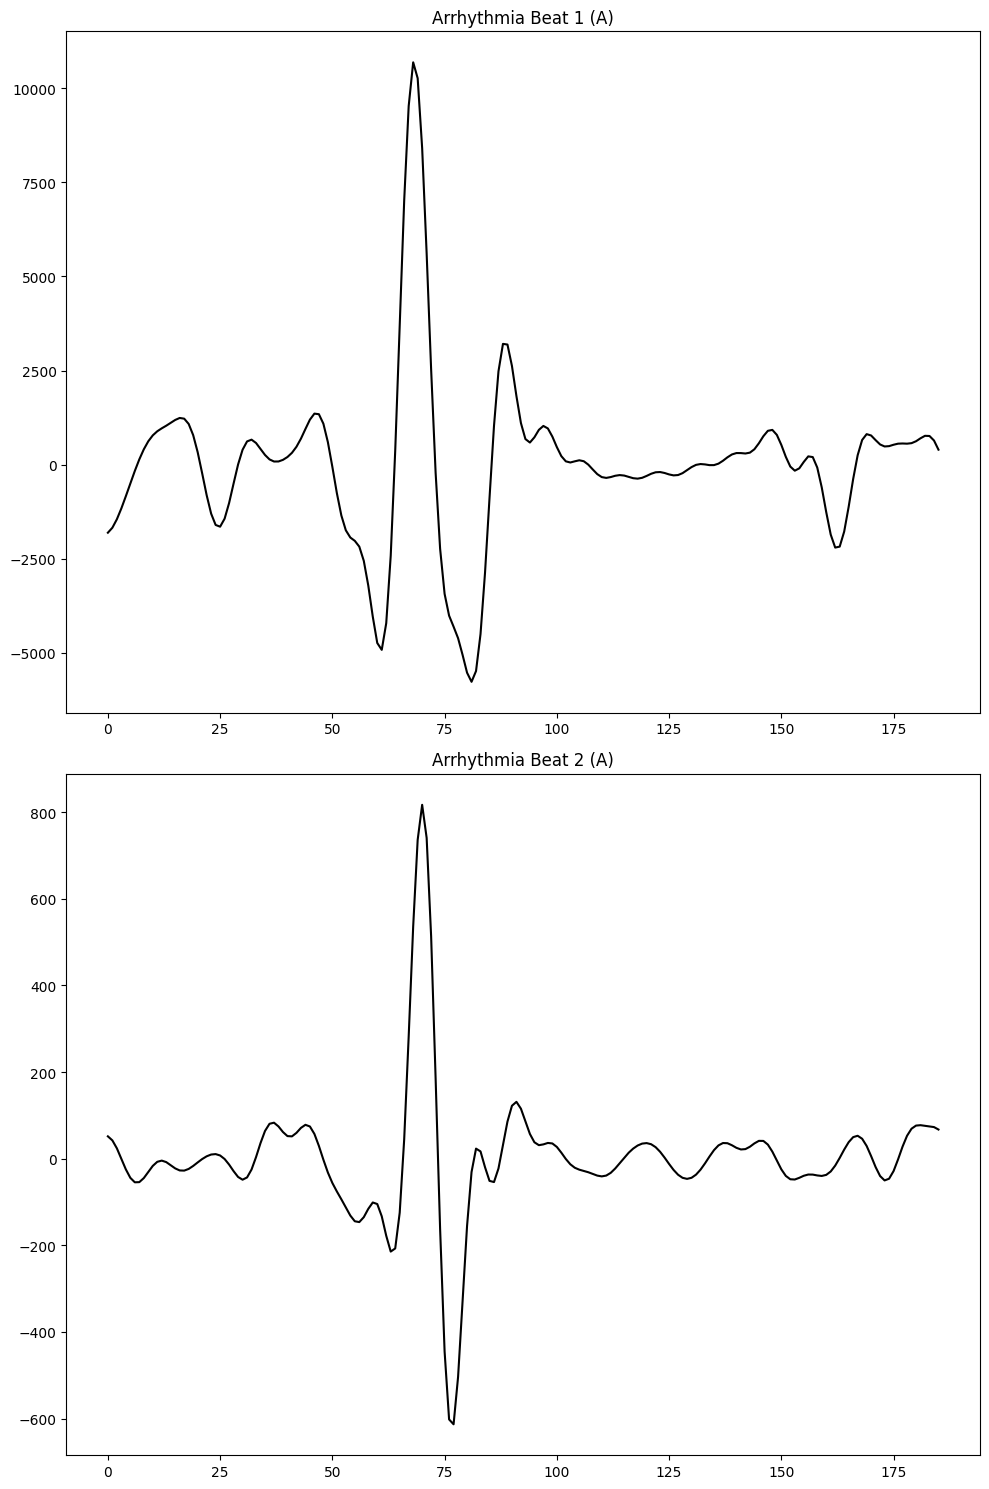

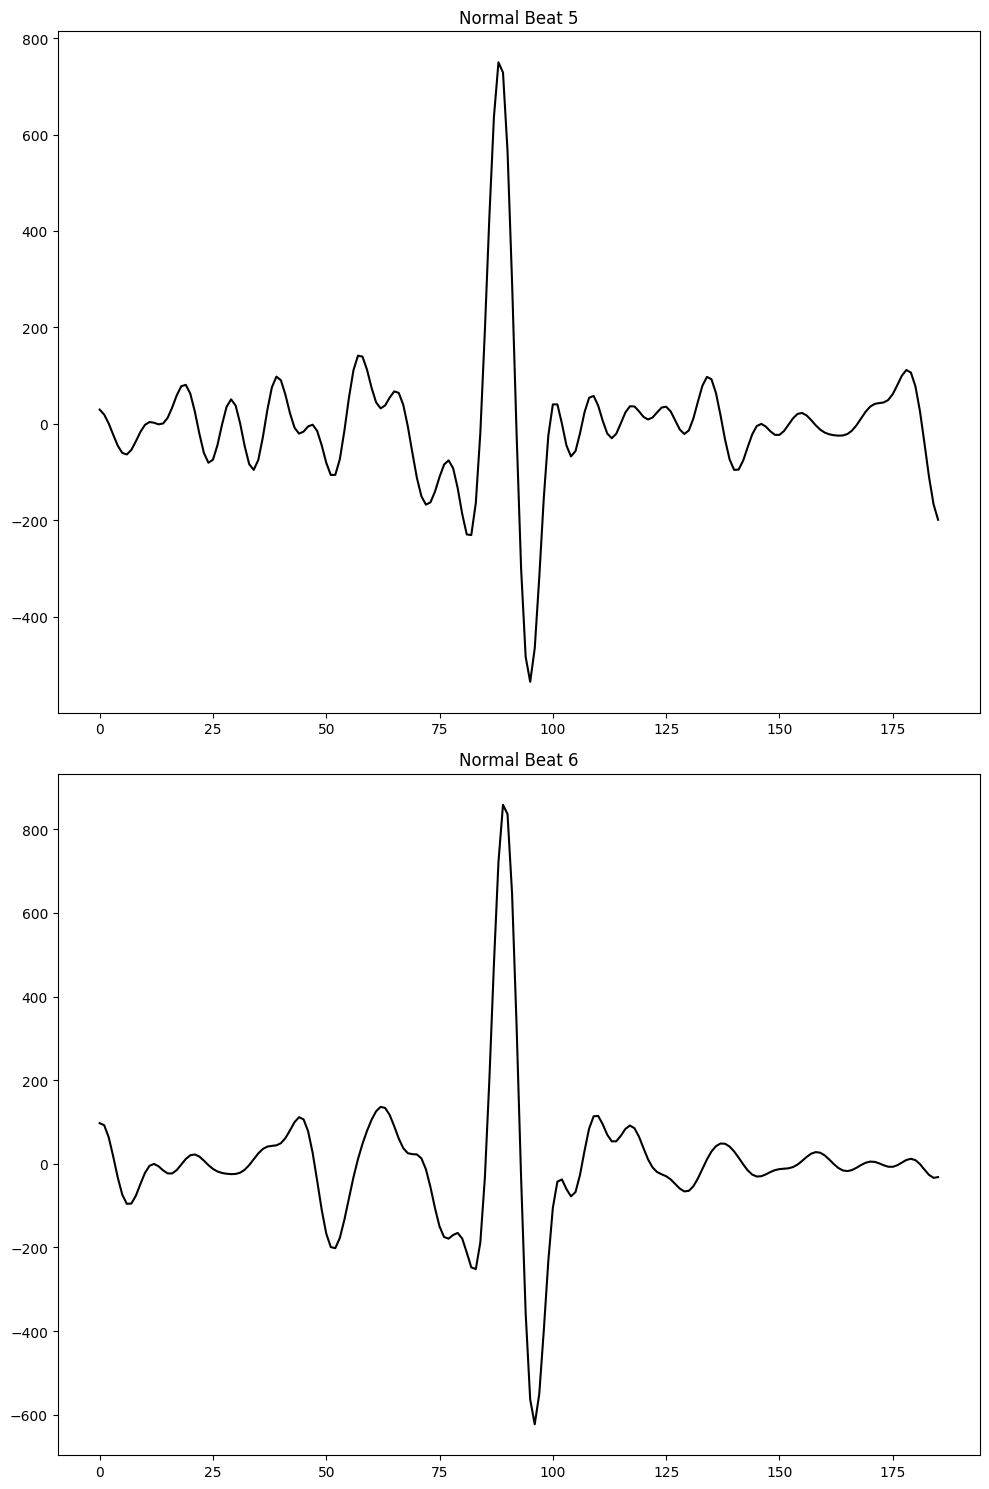

In [70]:
# Filter only the arrhythmia heartbeats (assuming non-arrhythmia heartbeats are labeled as 'N')
arrhythmia_df = results_df[results_df["Class"] != "N"]
num_arrhythmia_to_display = 2

# Filter only normal heartbeats
normal_df = results_df[results_df["Class"] == "N"]
num_normal_to_display = 2

# Plot the limited number of arrhythmia heartbeats
if not arrhythmia_df.empty:
    limited_arrhythmia_df = arrhythmia_df.head(num_arrhythmia_to_display)

    fig, axs = plt.subplots(nrows=num_arrhythmia_to_display, ncols=1, figsize=(10, 15))
    for i, ax in enumerate(axs):
        beat_index = limited_arrhythmia_df.iloc[i]["Beat"] - 1
        beat_class = limited_arrhythmia_df.iloc[i]["Class"]
        ax.plot(beats[beat_index], color="black")
        ax.set_title(f"Arrhythmia Beat {beat_index + 1} ({beat_class})")
    plt.tight_layout()
    plt.show()
else:
    print("No arrhythmia heartbeats found.")

# Plot the limited number of normal heartbeats if there are any
if not normal_df.empty:
    limited_normal_df = normal_df.head(num_normal_to_display)

    fig, axs = plt.subplots(nrows=num_normal_to_display, ncols=1, figsize=(10, 15))
    for i, ax in enumerate(axs):
        beat_index = limited_normal_df.iloc[i]["Beat"] - 1
        ax.plot(beats[beat_index], color="black")
        ax.set_title(f"Normal Beat {beat_index + 1}")
    plt.tight_layout()
    plt.show()
else:
    print("No normal heartbeats found.")